In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# from logitboost import LogitBoost
# from autogluon.tabular import TabularDataset, TabularPredictor

import imodels
import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def predict_stats(y_true, y_pred_prob, verbose = True) :
    '''
    Choose the threshold for probability using Youden's J-statistic (tpr - fpr),
    then prints AUC, accuracy, balanced accuracy, sensitivity, and specificity
    
    input
    ------
    y_true      : true outcome values
    y_pred_prob : predicted probability of being positive (tbi)
    verbose     : Print the statistics or not
    
    output
    ------
    Prints (if verbose = True) and returns the dictionary containing statistics
    (AUC, accuracy, balanced accuracy, sensitivity, specificity)
    '''
    
    from sklearn.metrics import confusion_matrix
    
    fpr, tpr, thresholds = roc_curve(y_tune, y_pred_prob)
    J = tpr - fpr
    thresh = thresholds[np.argmax(J)]  
    y_tune_pred = y_pred_prob > thresh

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_tune_pred)
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_tune, y_pred_prob)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    balacc = (sens + spec) / 2
    
    if verbose :
        print('Confusion Matrix : \n', cm)
        print(f'Prob. threshold : {thresh:.5f}')
        print(f'AUC             : {auc:.3f}')  
        print(f'Accuracy        : {acc:.3f}')
        print(f'Sensitivity     : {sens:.3f}')
        print(f'Specificity     : {spec:.3f}')
        print(f'Balanced Acc.   : {balacc:.3f}')

    return {'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, "Sensitivity" : sens, "Specificity" : spec}

In [5]:
##################
# DATA SELECTION #
##################

simple = True    # 43 Columns or 118 Columns
young = True     # Include Age < 2                  (6432 + 2144 + 2145 samples)
old = True        # Include Age > 2                  (19025 + 6342 + 6432 samples)

    
df_train, df_tune, df_test = Dataset().get_data(simple=simple, young=young, old=old)
outcome_def = 'outcome'
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


/Users/sahilsaxena/rule-env/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/sahilsaxena/Desktop/stat-215-a/rule-vetting/rulevetting/projects/tbi_pecarn/dataset.py:367: UserWarning: Persisting input arguments took 18.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  preprocessed_data = cache(self.preprocess_data)(cleaned_data, **default_kwargs['preprocess_data'])


In [25]:
# SANITY CHECK
train_positive_prop = sum(y_train == 1) / len(y_train)
tune_positive_prop = sum(y_tune == 1) / len(y_tune)

train_positive_prop, tune_positive_prop

(0.009113048943357687, 0.009898656610888523)

Using an SVM is an interpretable way to model our data and consequently, learn more about it. 

# SVM, with RBF kernal, on simple (all ages)

In [37]:
lamb_vec = [2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(2), 2**(4), 2**(6)]
roc_tune_svm_rbf = []
acc_tune_svm_rbf = []
i = 1
for c in lamb_vec:
    svm_v = svm.SVC(C = c, probability=True).fit(X_train, y_train)
    roc_tune_svm_rbf.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
    acc_tune_svm_rbf.append(svm_v.score(X_tune, y_tune))
    print(f"{i} down, {len(lamb_vec) - i} to go")
    i += 1

print("Validation AUC:", np.around(roc_tune_svm_rbf, 5))
print("Validation ACC:", np.around(acc_tune_svm_rbf, 5))

1 down, 7 to go
2 down, 6 to go
3 down, 5 to go
4 down, 4 to go
5 down, 3 to go
6 down, 2 to go
7 down, 1 to go
8 down, 0 to go
Validation AUC: [0.62096 0.63625 0.63414 0.64601 0.647   0.64507 0.66575 0.62762]
Validation ACC: [0.9901  0.9901  0.9901  0.9901  0.9901  0.9901  0.98963 0.98739]


In [39]:
best_lamb = lamb_vec[np.argmax(np.array(roc_tune_svm_rbf))]
print("Optimal C:", np.around(best_lamb, 5))

Optimal C: 16


Train Accuracy: 0.9931652132924818
Train AUC: 0.9690526946746242
Tune AUC: 0.6657513517189784
Tune ACC: 0.9896299787885929


100%|██████████████████████████████████████| 3342/3342 [00:03<00:00, 910.14it/s]


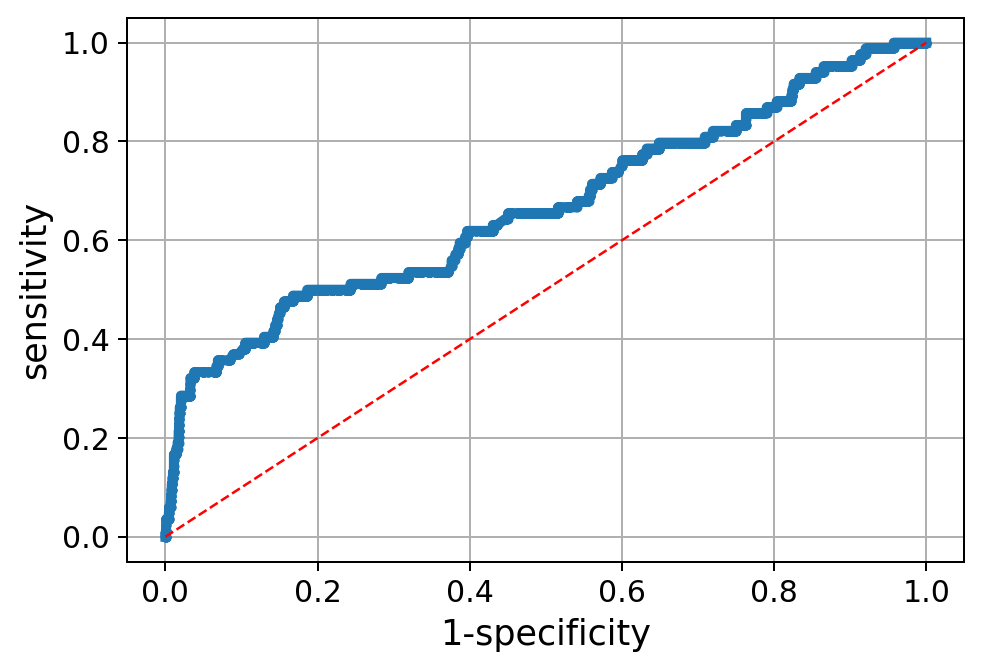

In [55]:
svm_rbf_final = svm.SVC(C = best_lamb, probability=True).fit(X_train, y_train)
print("Train Accuracy:", svm_rbf_final.score(X_train, y_train))
print("Train AUC:", roc_auc_score(y_train, svm_rbf_final.predict_proba(X_train)[:, 1]))
print("Tune AUC:", roc_auc_score(y_tune, svm_rbf_final.predict_proba(X_tune)[:, 1])) 
print("Tune ACC:", svm_rbf_final.score(X_tune, y_tune))

# Plot the result for the tune set
validation.all_stats_curve(y_tune, svm_rbf_final.predict_proba(X_tune)[:, 1], plot = True)
plt.show()

In [44]:
predict_stats(y_tune, svm_rbf_final.predict_proba(X_tune)[:, 1])

Confusion Matrix : 
 [[6994 1408]
 [  44   40]]
Prob. threshold : 0.01464
AUC             : 0.666
Accuracy        : 0.829
Sensitivity     : 0.832
Specificity     : 0.476
Balanced Acc.   : 0.654


{'AUC': 0.6657513517189784,
 'Accuracy': 0.8288946500117841,
 'Balanced Accuracy': 0.6543056641842645,
 'Sensitivity': 0.8324208521780528,
 'Specificity': 0.47619047619047616}

# SVM, with Linear kernal, on simple (all ages)

In [46]:
lamb_vec = [2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(2), 2**(4), 2**(6)]
roc_tune_svm_lin = []
acc_tune_svm_lin = []
i = 1
for c in lamb_vec:
    svm_v = svm.SVC(C = c, kernel = 'linear', probability=True).fit(X_train, y_train)
    roc_tune_svm_lin.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
    acc_tune_svm_lin.append(svm_v.score(X_tune, y_tune))
    print(f"{i} down, {len(lamb_vec) - i} to go")
    i += 1

print("Validation AUC:", np.around(roc_tune_svm_lin, 5))
print("Validation ACC:", np.around(acc_tune_svm_lin, 5))

1 down, 7 to go
2 down, 6 to go
3 down, 5 to go
4 down, 4 to go
5 down, 3 to go
6 down, 2 to go
7 down, 1 to go
8 down, 0 to go
Validation AUC: [0.50244 0.5321  0.66284 0.40661 0.72326 0.62543 0.3924  0.34005]
Validation ACC: [0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901]


In [47]:
best_lamb_lin = lamb_vec[np.argmax(np.array(roc_tune_svm_lin))]
print("Optimal C:", np.around(best_lamb_lin, 5))

Optimal C: 0.25


Train Accuracy: 0.9908869510566423
Train AUC: 0.7748634242995049
Tune AUC: 0.7232546672560956
Tune ACC: 0.9901013433891115


100%|██████████████████████████████████████| 3342/3342 [00:04<00:00, 829.57it/s]


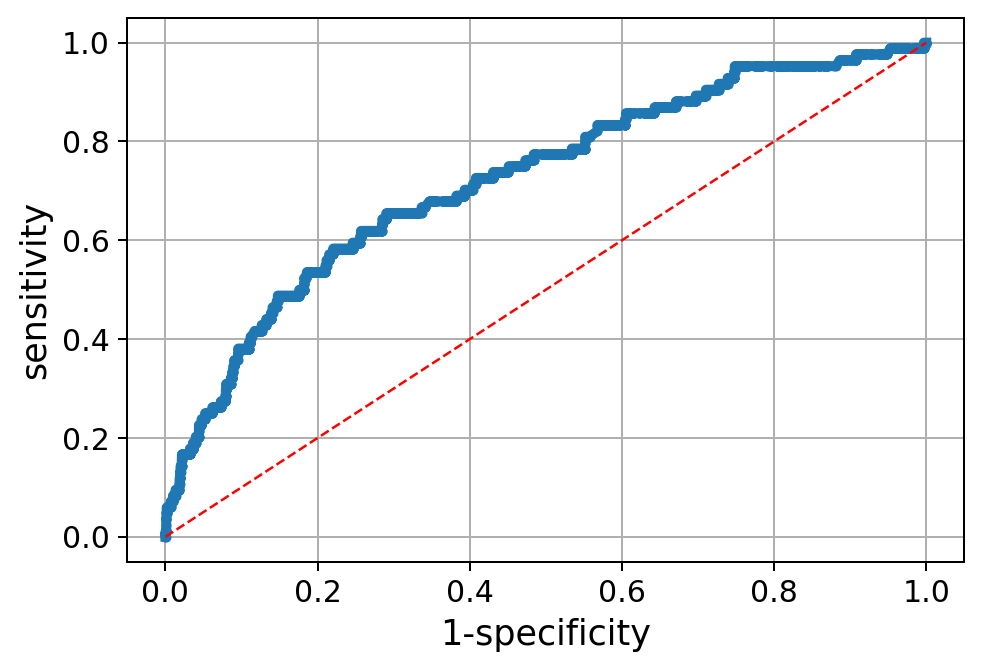

In [54]:
svm_lin_final = svm.SVC(C = best_lamb_lin, kernel = 'linear', probability=True).fit(X_train, y_train)
print("Train Accuracy:", svm_lin_final.score(X_train, y_train))
print("Train AUC:", roc_auc_score(y_train, svm_lin_final.predict_proba(X_train)[:, 1]))
print("Tune AUC:", roc_auc_score(y_tune, svm_lin_final.predict_proba(X_tune)[:, 1])) 
print("Tune ACC:", svm_lin_final.score(X_tune, y_tune))

# Plot the result for the tune set
validation.all_stats_curve(y_tune, svm_lin_final.predict_proba(X_tune)[:, 1], plot = True)
plt.show()

In [51]:
predict_stats(y_tune, svm_lin_final.predict_proba(X_tune)[:, 1])

Confusion Matrix : 
 [[5962 2440]
 [  30   54]]
Prob. threshold : 0.00848
AUC             : 0.723
Accuracy        : 0.709
Sensitivity     : 0.710
Specificity     : 0.643
Balanced Acc.   : 0.676


{'AUC': 0.7232575010485032,
 'Accuracy': 0.7089323591798256,
 'Balanced Accuracy': 0.6762250484578503,
 'Sensitivity': 0.7095929540585575,
 'Specificity': 0.6428571428571429}

<AxesSubplot:title={'center':'Top 12 Feature Coefficients'}>

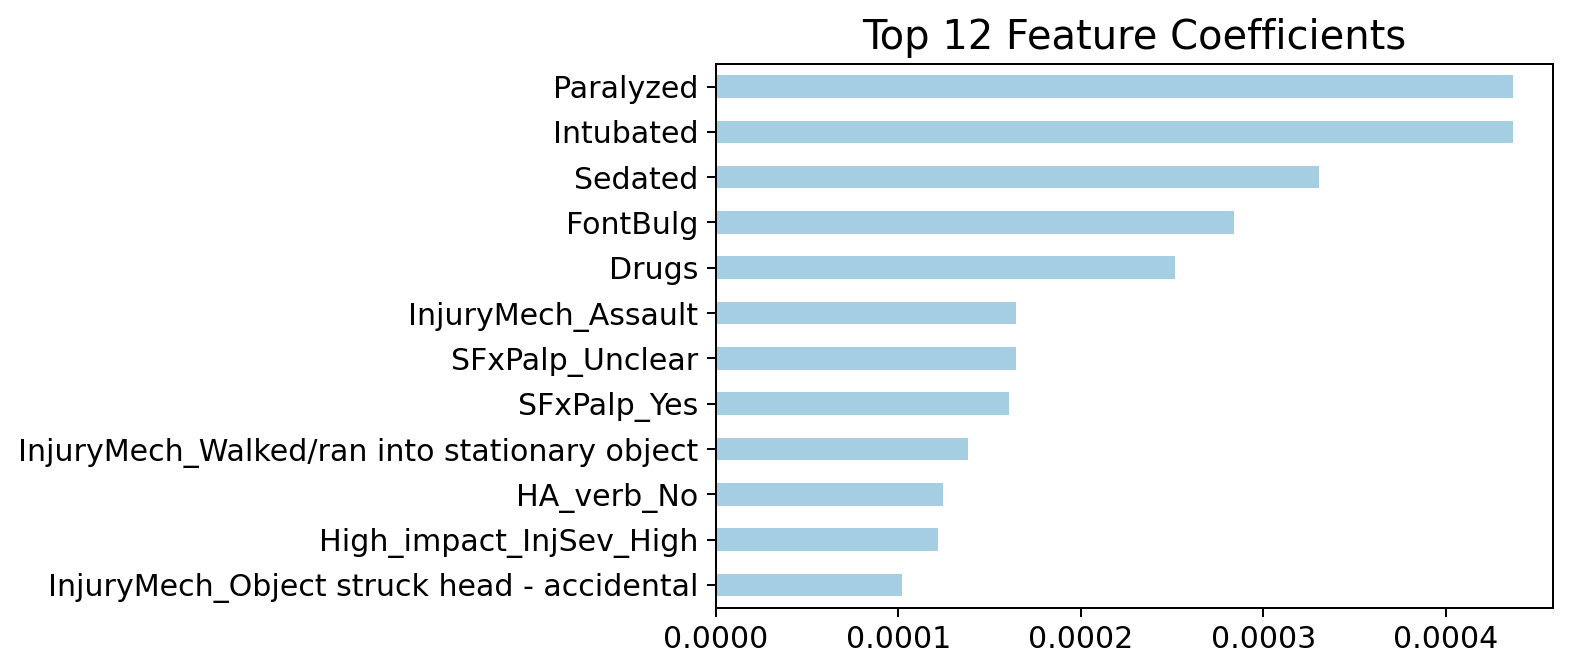

In [91]:
pd.Series(abs(svm_lin_final.coef_[0]), index=X_train.columns).nlargest(12).sort_values(ascending=True).plot(
    kind='barh', label = 'index', colormap = 'Paired', title = 'Top 12 Feature Coefficients'
)

In [99]:
# constants
lamb_vec = [2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(2), 2**(4), 2**(6)]
outcome_def = 'outcome'

def run_svm(kernel, simple, young, old):
    print(f"SVM with {kernel} kernel\n")
    
    # get data
    print("Getting dataset")
    df_train, df_tune, df_test = Dataset().get_data(simple=simple, young=young, old=old)
    X_train = df_train.drop(columns=outcome_def)
    y_train = df_train[outcome_def].values
    X_tune = df_tune.drop(columns=outcome_def)
    y_tune = df_tune[outcome_def].values
    
    # run validation
    roc_tune_svm = []
    acc_tune_svm = []
    for c in lamb_vec:
        svm_v = svm.SVC(kernel = kernel, C = c, probability=True).fit(X_train, y_train)
        roc_tune_svm.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
        acc_tune_svm.append(svm_v.score(X_tune, y_tune))
    print("\nValidation AUC:", np.around(roc_tune_svm, 5))
    print("Validation ACC:", np.around(acc_tune_svm, 5))
    
    best_lamb = lamb_vec[np.argmax(np.array(roc_tune_svm))]
    print("\nOptimal C:", np.around(best_lamb, 5))
    
    # choose final model
    svm_final = svm.SVC(kernel = kernel, C = best_lamb, probability=True).fit(X_train, y_train)
    print("\nTrain AUC:", roc_auc_score(y_train, svm_final.predict_proba(X_train)[:, 1]))
    print("Train ACC:", svm_final.score(X_train, y_train))
    print("Tune AUC:", roc_auc_score(y_tune, svm_final.predict_proba(X_tune)[:, 1])) 
    print("Tune ACC:", svm_final.score(X_tune, y_tune))

    # Plot the result for the tune set
    validation.all_stats_curve(y_tune, svm_final.predict_proba(X_tune)[:, 1], plot = True)
    plt.show()
    
    # full stats summary
    print()
    predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1])
    
    # feature importance
    if kernel == 'linear':
        print()
        pd.Series(abs(svm_final.coef_[0]), index=X_train.columns).nlargest(12).sort_values(ascending=True).plot(
            kind='barh', label = 'index', colormap = 'Paired', title = 'Top 12 Feature Coefficients'
        )

# SVM, with RBF kernal, on simple (young only)

SVM with rbf kernel

Getting dataset
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}

Validation AUC: [0.76259 0.76734 0.7663  0.76759 0.76635 0.77378 0.77619 0.76785]
Validation ACC: [0.9901  0.9901  0.9901  0.9901  0.9901  0.98998 0.98928 0.98692]

Optimal C: 16

Train AUC: 0.9944881888418353
Train ACC: 0.9974467750805248
Tune AUC: 0.7761998277054216
Tune ACC: 0.9892764553382041


100%|██████████████████████████████████████| 5468/5468 [00:06<00:00, 905.19it/s]


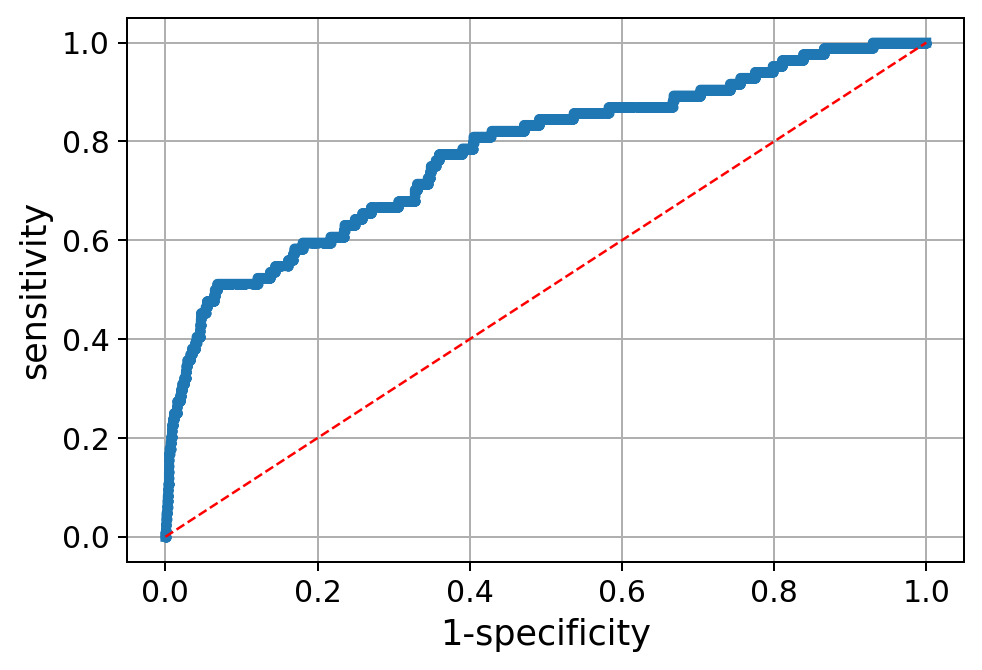


Confusion Matrix : 
 [[7828  574]
 [  42   42]]
Prob. threshold : 0.01899
AUC             : 0.776
Accuracy        : 0.927
Sensitivity     : 0.932
Specificity     : 0.500
Balanced Acc.   : 0.716


In [100]:
run_svm('rbf', True, True, False)

# SVM, with RBF kernal, on simple (old only)

SVM with rbf kernel

Getting dataset
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}

Validation AUC: [0.76259 0.76734 0.7663  0.76759 0.76635 0.77378 0.77619 0.76785]
Validation ACC: [0.9901  0.9901  0.9901  0.9901  0.9901  0.98998 0.98928 0.98692]

Optimal C: 16

Train AUC: 0.9944881888418353
Train ACC: 0.9974467750805248
Tune AUC: 0.7761998277054216
Tune ACC: 0.9892764553382041


100%|██████████████████████████████████████| 5468/5468 [00:06<00:00, 800.26it/s]


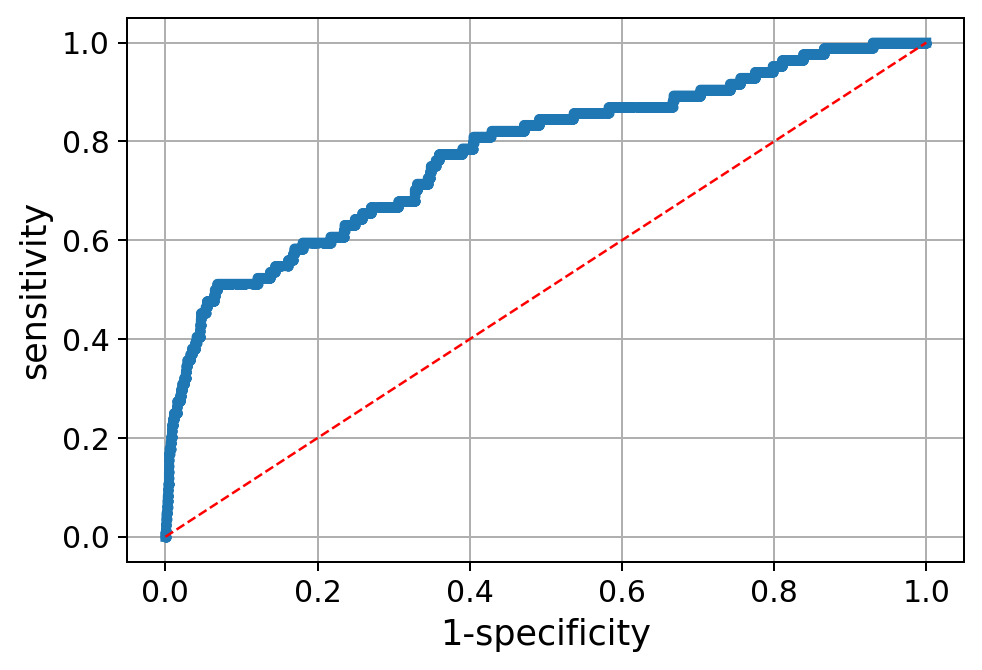


Confusion Matrix : 
 [[7828  574]
 [  42   42]]
Prob. threshold : 0.01899
AUC             : 0.776
Accuracy        : 0.927
Sensitivity     : 0.932
Specificity     : 0.500
Balanced Acc.   : 0.716


In [101]:
run_svm('rbf', True, False, True)

# SVM, with RBF kernal, on regular (all ages)

In [ ]:
run_svm('rbf', False, True, True)

# SVM, with RBF kernal, on regular (young only)

In [ ]:
run_svm('rbf', False, True, False)

# SVM, with RBF kernal, on regular (old only)

In [ ]:
run_svm('rbf', False, False, True)

# SVM, with Linear kernal, on simple (young only)

In [ ]:
run_svm('linear', True, True, False)

# SVM, with Linear kernal, on simple (old only)

In [ ]:
run_svm('linear', True, False, True)

# SVM, with Linear kernal, on regular (all ages)

In [ ]:
run_svm('linear', False, True, True)

# SVM, with Linear kernal, on regular (young only)

In [ ]:
run_svm('linear', False, True, False)

# SVM, with Linear kernal, on regular (old only)

In [ ]:
run_svm('linear', False, False, True)